In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## data

In [2]:
idx = ['P3HT vol (µL)','D1 vol (µL)', 'D2 vol (µL)', 'D6 vol (µL)', 'D8 vol (µL)',]

In [3]:
# note: there are 20 independent BO tests, each test Step batch-BO 20 steps
# in each test, number of initial points = 50, num of batch = 9
data_orgs = []
for i in range(1,21):
    data_orgs.append(pd.read_excel('BO-history-Cond-final.xlsx', sheet_name='Test%d'%i).rename(columns={'run':'Step'}))

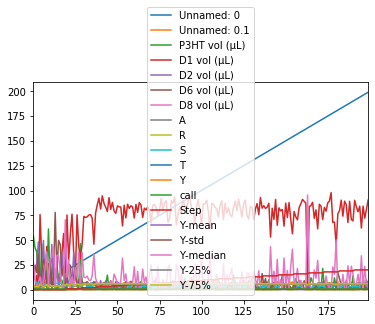

In [4]:
data_orgs[0].plot()

### best row

In [5]:
data_best_rows,data_best_rows_re = [],[]
for data_org in data_orgs:
    t = data_org
    data_best_rows.append(t[t['Y']==t['Y'].max()])
    data_best_rows_re.append(t[t['Y-mean']==t['Y-mean'].max()])
data_best_rows = pd.concat(data_best_rows)
data_best_rows_re = pd.concat(data_best_rows_re)

## plot for the target y (Y)

In [6]:
data_orgs_max = []
for data in data_orgs:
    data_orgs_max.append(data.groupby('Step',as_index=False).max())

In [7]:
# data_org = pd.concat(data_orgs,ignore_index=True,sort=False).dropna(axis=0,how='all',)
data_org_max = pd.concat(data_orgs_max,ignore_index=True,sort=False).dropna(axis=0,how='all',)
data_org_max['Y (*)'] = data_org_max['Y-mean']

### plot

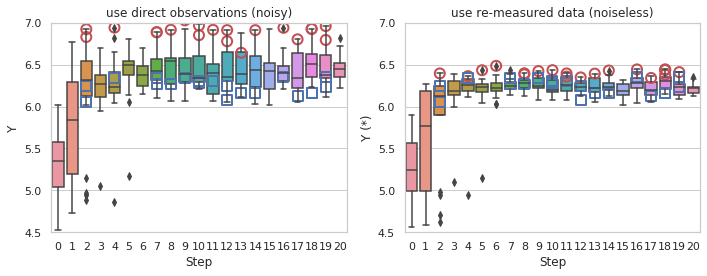

In [34]:
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
sns.boxplot(x="Step", y="Y", data=data_org_max)
plt.ylim([4.5,7]);plt.title('use direct observations (noisy)')
plt.scatter(data_best_rows['Step'],data_best_rows['Y'],
            marker='o',c='',edgecolors='r',linewidths=2,s=100)
plt.scatter(data_best_rows['Step'],data_best_rows['Y-mean'],
            marker='s',c='',edgecolors='b',linewidths=2,s=100)

plt.subplot(1,2,2)
sns.boxplot(x="Step", y="Y (*)", data=data_org_max)
plt.ylim([4.5,7]);plt.title('use re-measured data (noiseless)');
plt.scatter(data_best_rows_re['Step'],data_best_rows_re['Y-mean'],
            marker='o',c='',edgecolors='r',linewidths=2,s=100)
plt.scatter(data_best_rows['Step'],data_best_rows['Y-mean'],
            marker='s',c='',edgecolors='b',linewidths=2,s=100)

# note: here direct Cond is larger than re-measured Cond, since we maximized Cond over each batch
# max{cond+noise} > max{cond} since the positive noises are maintained
plt.tight_layout()
# plt.savefig('BO_Convergence_Target.png')
# plt.savefig('BO_Convergence_Target.pdf')

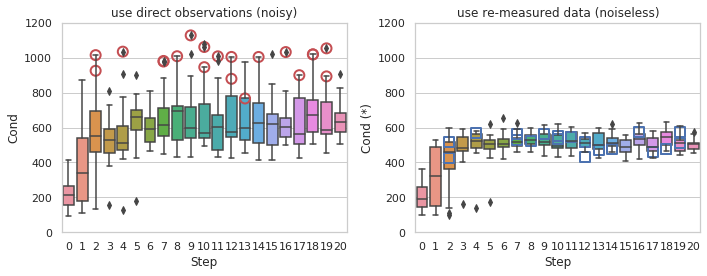

In [43]:
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
data_org_max['Cond'] = np.exp(data_org_max['Y'])
sns.boxplot(x="Step", y="Cond", data=data_org_max)
plt.ylim([0,1200]);plt.title('use direct observations (noisy)')
plt.scatter(data_best_rows['Step'],np.exp(data_best_rows['Y']),
            marker='o',c='',edgecolors='r',linewidths=2,s=100)
# plt.scatter(data_best_rows['Step'],np.exp(data_best_rows['Y-mean']),
#             marker='s',c='',edgecolors='b',linewidths=2,s=100)

plt.subplot(1,2,2)
data_org_max['Cond (*)'] = np.exp(data_org_max['Y (*)'])
sns.boxplot(x="Step", y="Cond (*)", data=data_org_max)
plt.ylim([0,1200]);plt.title('use re-measured data (noiseless)');
# plt.scatter(data_best_rows_re['Step'],np.exp(data_best_rows_re['Y-mean']),
#             marker='o',c='',edgecolors='r',linewidths=2,s=100)
plt.scatter(data_best_rows['Step'],np.exp(data_best_rows['Y-mean']),
            marker='s',c='',edgecolors='b',linewidths=2,s=100)

# note: here direct Cond is larger than re-measured Cond, since we maximized Cond over each batch
# max{cond+noise} > max{cond} since the positive noises are maintained
plt.tight_layout()
plt.savefig('BO_Convergence_Target.png')
plt.savefig('BO_Convergence_Target.pdf')

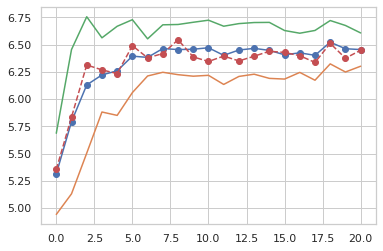

In [23]:
cond_mean = data_org_max.groupby('Step').mean()
cond_median = data_org_max.groupby('Step').median()
cond_std = data_org_max.groupby('Step').std()
mean,std = cond_mean['Y'],cond_std['Y']
plt.plot(mean,'-o')
plt.plot(mean-std,'-')
plt.plot(mean+std,'-')
plt.plot(cond_median['Y'],'--o')
# plt.plot(cond_mean['Y-mean'],'--')
# plt.plot(cond_mean['Y-median'],'-.')

## plot for the input x (content)

### determine the best content

In [10]:
data_org = pd.concat(data_orgs)

In [11]:
len(data_org)

4000

In [12]:
data = data_org.sort_values(by='Y',ascending=False) # use the best from direct observations
x_best = data[idx].values[0]
data = data_org.sort_values(by='Y-mean',ascending=False) # use the best from re-measured values
x_best_re = data[idx].values[0]

In [13]:
x_best,x_best_re

(array([ 0.52103873, 95.17758738,  1.01933788,  1.95985302,  1.34514795]),
 array([ 0.21868041, 96.97368889,  0.96279646,  0.49123089,  1.36019385]))

### select the x with best y (in each batch)

In [14]:
def dist_to_best(x):
    return np.linalg.norm(x-x_best,axis=1)
def dist_to_best_re(x):
    return np.linalg.norm(x-x_best_re,axis=1)

In [15]:
data_orgs_dist = []
for data_org in data_orgs:
    data = data_org.groupby('Step',as_index=False).apply(lambda t:t[t['Y']==t['Y'].max()])
#     data = data[idx]
    data['Distance'] = dist_to_best(data.loc[:,idx])
    data['Distance (*)'] = dist_to_best_re(data.loc[:,idx])
    data_orgs_dist.append(data)

In [16]:
data_org_dist = pd.concat(data_orgs_dist)

In [17]:
for data in [data_best_rows,data_best_rows_re]:
    data['Distance'] = dist_to_best(data.loc[:,idx])
    data['Distance (*)'] = dist_to_best_re(data.loc[:,idx])

### plot

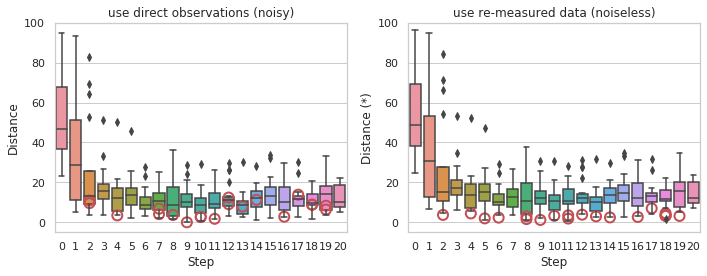

In [39]:
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=[10,4])
plt.subplot(121)
sns.boxplot(x="Step", y="Distance", data=data_org_dist)
plt.ylim([-5,100]);plt.title('use direct observations (noisy)')
plt.scatter(data_best_rows['Step'],data_best_rows['Distance'],
            marker='o',c='',edgecolors='r',linewidths=2,s=100)

plt.subplot(122)
sns.boxplot(x="Step", y="Distance (*)", data=data_org_dist)
plt.ylim([-5,100]);plt.title('use re-measured data (noiseless)');
plt.scatter(data_best_rows_re['Step'],data_best_rows_re['Distance'],
            marker='o',c='',edgecolors='r',linewidths=2,s=100)

plt.tight_layout()
plt.savefig('BO_Convergence_Inputs.png')
plt.savefig('BO_Convergence_Inputs.pdf')